# Setup

In [1]:
import subprocess
import tempfile
import os
import struct
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import time
import random

os.chdir(Path.cwd().parent)

from rtl.py_lmul import lmul
from rtl.lmul_tester import BatchLMULTester, BatchLMULTesterParallel
from rtl.numpy_lmul import lmul_numpy_vectorized
from utils.floats import (
    float_to_bf16,
    bf16_to_float,
    float_to_bf16_array,
    bf16_to_float_array
)

try:
    import torch
    from rtl.pytorch_lmul import lmul_torch_vectorized
    from utils.floats import float_to_bf16_tensor, bf16_to_float_tensor
    TORCH_AVAILABLE = True
except ImportError:
    TORCH_AVAILABLE = False

# Utilities

# Tests

In [2]:
N = 10000
test_data = []
for _ in range(N):
    a_float = np.random.uniform(-10000, 10000)
    b_float = np.random.uniform(-10, 10)
    a_bf16 = float_to_bf16(a_float)
    b_bf16 = float_to_bf16(b_float)
    test_data.append((a_bf16, b_bf16, a_float, b_float))

In [3]:
# Run all implementations
tester = BatchLMULTester()
test_pairs = [(a_bf16, b_bf16) for a_bf16, b_bf16, _, _ in test_data]
lmul_res, _, _, _ = tester.test_batch(test_pairs)
lmul_results = np.array([bf16_to_float(res) for res in lmul_res]).astype(np.float32)

pylmul_results = []
for a_bf16, b_bf16, _, _ in test_data:
    pylmul_res = bf16_to_float(lmul(a_bf16, b_bf16))
    pylmul_results.append(pylmul_res)
pylmul_results = np.array(pylmul_results).astype(np.float32)

a_floats = np.array([d[2] for d in test_data], dtype=np.float32)
b_floats = np.array([d[3] for d in test_data], dtype=np.float32)
a_bf16_vec = float_to_bf16_array(a_floats)
b_bf16_vec = float_to_bf16_array(b_floats)
numpy_lmul_res_bf16 = lmul_numpy_vectorized(a_bf16_vec, b_bf16_vec)
numpy_lmul_results = bf16_to_float_array(numpy_lmul_res_bf16).astype(np.float32)

if TORCH_AVAILABLE:
    a_torch_bf16 = float_to_bf16_tensor(torch.from_numpy(a_floats))
    b_torch_bf16 = float_to_bf16_tensor(torch.from_numpy(b_floats))
    pytorch_lmul_res_bf16 = lmul_torch_vectorized(a_torch_bf16, b_torch_bf16)
    pytorch_lmul_results = bf16_to_float_tensor(pytorch_lmul_res_bf16).numpy().astype(np.float32)
else:
    pytorch_lmul_results = None

py_results = np.array([a_float * b_float for _, _, a_float, b_float in test_data]).astype(np.float32)

try:
    parallel_tester = BatchLMULTesterParallel()
    lmul_parallel_res, _ = parallel_tester.test_batch(test_pairs, verbose=False)
    if len(lmul_parallel_res) > N:
        lmul_parallel_res = lmul_parallel_res[:N]
    if len(lmul_parallel_res) == N:
        lmul_parallel_results = np.array([bf16_to_float(res) for res in lmul_parallel_res]).astype(np.float32)
    else:
        lmul_parallel_results = None
except Exception as e:
    lmul_parallel_results = None

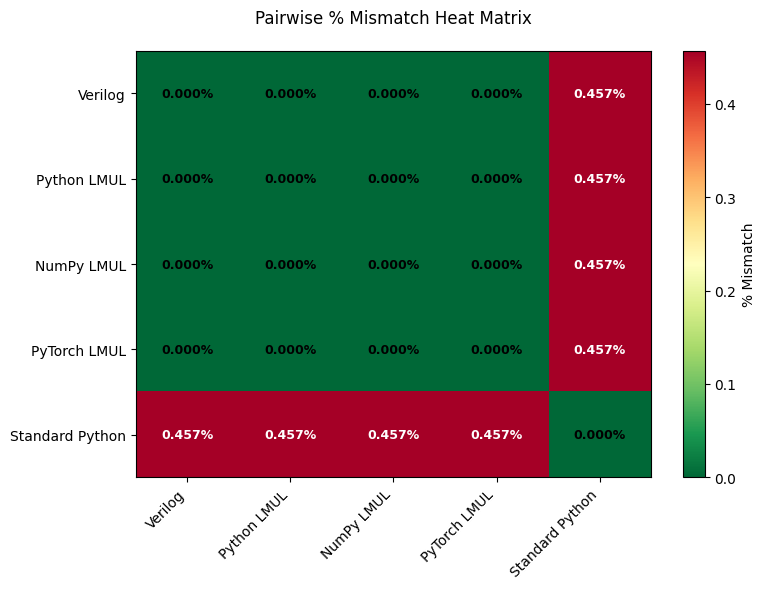

In [4]:
def compare_results(result1, result2, name1, name2, reference_range=None):
    """Compare two result arrays and report percentage mismatch."""
    if result1 is None or result2 is None:
        return None
    
    # Calculate differences
    abs_diff = np.abs(result1 - result2)
    mean_diff = np.mean(abs_diff)
    max_diff = np.max(abs_diff)
    
    # Calculate percentage mismatch
    if reference_range is not None and reference_range > 0:
        percent_mismatch = (mean_diff / reference_range) * 100
    else:
        # Use the range of the results themselves
        result_range = np.max([np.max(result1), np.max(result2)]) - np.min([np.min(result1), np.min(result2)])
        if result_range > 0:
            percent_mismatch = (mean_diff / result_range) * 100
        else:
            percent_mismatch = 0.0 if mean_diff == 0 else 100.0
    
    return {
        'mean_diff': mean_diff,
        'max_diff': max_diff,
        'percent_mismatch': percent_mismatch,
        'name1': name1,
        'name2': name2
    }

# Calculate reference range from standard Python multiplication
value_range = np.max(py_results) - np.min(py_results)

# Compare all implementations
comparisons = []

# Compare Verilog vs Python LMUL
comp = compare_results(lmul_results, pylmul_results, "Verilog", "Python LMUL", value_range)
if comp:
    comparisons.append(comp)

# Compare Verilog vs NumPy LMUL
comp = compare_results(lmul_results, numpy_lmul_results, "Verilog", "NumPy LMUL", value_range)
if comp:
    comparisons.append(comp)

# Compare Python vs NumPy LMUL
comp = compare_results(pylmul_results, numpy_lmul_results, "Python LMUL", "NumPy LMUL", value_range)
if comp:
    comparisons.append(comp)

# Compare PyTorch if available
if TORCH_AVAILABLE:
    comp = compare_results(lmul_results, pytorch_lmul_results, "Verilog", "PyTorch LMUL", value_range)
    if comp:
        comparisons.append(comp)
    
    comp = compare_results(pylmul_results, pytorch_lmul_results, "Python LMUL", "PyTorch LMUL", value_range)
    if comp:
        comparisons.append(comp)
    
    comp = compare_results(numpy_lmul_results, pytorch_lmul_results, "NumPy LMUL", "PyTorch LMUL", value_range)
    if comp:
        comparisons.append(comp)

# Compare LMUL vs standard multiplication (for reference)
comp = compare_results(lmul_results, py_results, "Verilog LMUL", "Standard Python", value_range)
if comp:
    comparisons.append(comp)

# Compare Verilog Parallel with other implementations (if available)
if lmul_parallel_results is not None and len(lmul_parallel_results) > 0:
    comp = compare_results(lmul_parallel_results, lmul_results, "Verilog Parallel", "Verilog", value_range)
    if comp:
        comparisons.append(comp)

    comp = compare_results(lmul_parallel_results, pylmul_results, "Verilog Parallel", "Python LMUL", value_range)
    if comp:
        comparisons.append(comp)

    comp = compare_results(lmul_parallel_results, numpy_lmul_results, "Verilog Parallel", "NumPy LMUL", value_range)
    if comp:
        comparisons.append(comp)

    if TORCH_AVAILABLE:
        comp = compare_results(lmul_parallel_results, pytorch_lmul_results, "Verilog Parallel", "PyTorch LMUL", value_range)
        if comp:
            comparisons.append(comp)

    comp = compare_results(lmul_parallel_results, py_results, "Verilog Parallel", "Standard Python", value_range)
    if comp:
        comparisons.append(comp)

# Create visualization - Heat matrix of all pairwise comparisons
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
# Collect all unique implementation names
all_implementations = []
implementation_results = {}
implementation_names = []

if len(lmul_results) > 0:
    all_implementations.append("Verilog")
    implementation_results["Verilog"] = lmul_results
    implementation_names.append("Verilog")

if lmul_parallel_results is not None and len(lmul_parallel_results) > 0:
    all_implementations.append("Verilog Parallel")
    implementation_results["Verilog Parallel"] = lmul_parallel_results
    implementation_names.append("Verilog Parallel")

if len(pylmul_results) > 0:
    all_implementations.append("Python LMUL")
    implementation_results["Python LMUL"] = pylmul_results
    implementation_names.append("Python LMUL")

if len(numpy_lmul_results) > 0:
    all_implementations.append("NumPy LMUL")
    implementation_results["NumPy LMUL"] = numpy_lmul_results
    implementation_names.append("NumPy LMUL")

if TORCH_AVAILABLE and pytorch_lmul_results is not None and len(pytorch_lmul_results) > 0:
    all_implementations.append("PyTorch LMUL")
    implementation_results["PyTorch LMUL"] = pytorch_lmul_results
    implementation_names.append("PyTorch LMUL")

# Add standard Python multiplication
if len(py_results) > 0:
    all_implementations.append("Standard Python")
    implementation_results["Standard Python"] = py_results
    implementation_names.append("Standard Python")

# Build comparison matrix
n = len(all_implementations)
if n > 0:
    heat_matrix = np.zeros((n, n))
    
    for i, impl1 in enumerate(all_implementations):
        for j, impl2 in enumerate(all_implementations):
            if i == j:
                heat_matrix[i, j] = 0.0  # Same implementation
            else:
                comp = compare_results(
                    implementation_results[impl1],
                    implementation_results[impl2],
                    impl1, impl2, value_range
                )
                if comp:
                    heat_matrix[i, j] = comp['percent_mismatch']
                else:
                    heat_matrix[i, j] = np.nan
    
    # Create heatmap
    max_val = heat_matrix[~np.isnan(heat_matrix)].max() if np.any(~np.isnan(heat_matrix)) else 0.1
    im = ax.imshow(heat_matrix, cmap='RdYlGn_r', aspect='auto', vmin=0, vmax=max(max_val, 0.1))
    ax.set_xticks(range(n))
    ax.set_yticks(range(n))
    ax.set_xticklabels(implementation_names, rotation=45, ha='right', fontsize=10)
    ax.set_yticklabels(implementation_names, fontsize=10)
    ax.set_title('Pairwise % Mismatch Heat Matrix', fontsize=12, pad=20)
    
    # Add text annotations
    for i in range(n):
        for j in range(n):
            val = heat_matrix[i, j]
            if not np.isnan(val):
                text = f'{val:.3f}%' if val > 0 else '0.000%'
                color = 'white' if val > max_val / 2 else 'black'
                ax.text(j, i, text, ha='center', va='center', 
                        color=color, fontsize=9, weight='bold')
    
    # Add colorbar
    cbar = plt.colorbar(im, ax=ax)
    cbar.set_label('% Mismatch', fontsize=10)
else:
    ax.text(0.5, 0.5, 'No data available', 
             ha='center', va='center', transform=ax.transAxes, fontsize=12)
    ax.set_title('Pairwise Comparison Heat Matrix', fontsize=12)

plt.tight_layout()
plt.show()